In [ ]:
# Now install the required packages.
# If any of the packages fails to install, they should be installed again.
# May take a lot of time
!pip install pandas scikit-learn matplotlib numpy seaborn

# Download the data files that will be used to the current directory
# The data will be downloaded from online sources
# The estimate size will be indicated against each url
#crash_report_file = "crash_report.csv"
#crash_report_url = "https://data.tempe.gov/api/download/v1/items/0c333bd164d64d62aa0ee6f99b1ccf82/csv?layers=0" # 20MiB
#us_statewide_crash_report_file = "statewide-travel-and-crash-summary.csv"
#us_statewide_crash_report_url = "https://data.ca.gov/dataset/7d8ae1dd-e948-42ae-9914-ff6fc622147b/resource/c25e0bd2-f0dd-47b1-bfc4-f1cf4530a249/download/statewide-travel-and-crash-summary.csv" # 8B
driver_crash_report_file = "driver_crash_report.csv"
driver_crash_report_url = "https://data.montgomerycountymd.gov/api/views/mmzv-x632/rows.csv?accessType=DOWNLOAD" # 84MiB

# Create a dictionary to use when checking the filenames
datas_dict = {driver_crash_report_file: driver_crash_report_url}

# Instead of downoading everytime, check if the file(s) exist locally and use them instead
from pathlib import Path
import requests

for filename, fileurl in datas_dict.items():
    # Check if the path exists, is a file and has something inside
    if Path(filename).is_file():
        print(f"{filename} exists, will use this copy for subsequent operations!\n")
    else:
        print(f"Expected `{filename}' to exist but din't find it, will have to download from `{fileurl}'\n")
        r = requests.get(fileurl, allow_redirects=True)
        with open(filename, "w") as f:
            f.write(str(r.content))
            print(f"Written to {filename} succesfully!")

## Train the model using the data given

In [114]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

# Deal with the data having malformed input (O)
def case_conv(val, default_val=0):
    """
        Given an input, convert it into an int, if not possible, return default_val
    """
    try:
        return int(val)
    except ValueError:
        return default_val

data = pd.read_csv(driver_crash_report_file,skip_blank_lines=True, converters={"Local Case Number": case_conv})

iscol = "Injury Severity"

# Do data cleanup on the rows
data.dropna(subset=[iscol], inplace=True)
data.drop_duplicates(keep=False, inplace=True)

# Do some preprocessing since model.fit() doesn't actually accept strings!
# Code from: https://stackoverflow.com/a/49271663
le = preprocessing.LabelEncoder()
for column_name in data.columns:
    if data[column_name].dtype == object:
        data[column_name] = le.fit_transform(data[column_name])
    else:
        pass

x=data.drop([iscol], axis=1).values
y=data[iscol].values

x_train,x_test, y_train,y_test =  train_test_split(x,y,test_size=0.2,random_state=42)
model = LinearRegression()
model.fit(x_train,y_train)

y_pred = model.predict(x_test)

## Evaluate the model

In [117]:
from sklearn.metrics import r2_score

r2_score(y_test,y_pred)

0.3480340944471251

## Plot the results

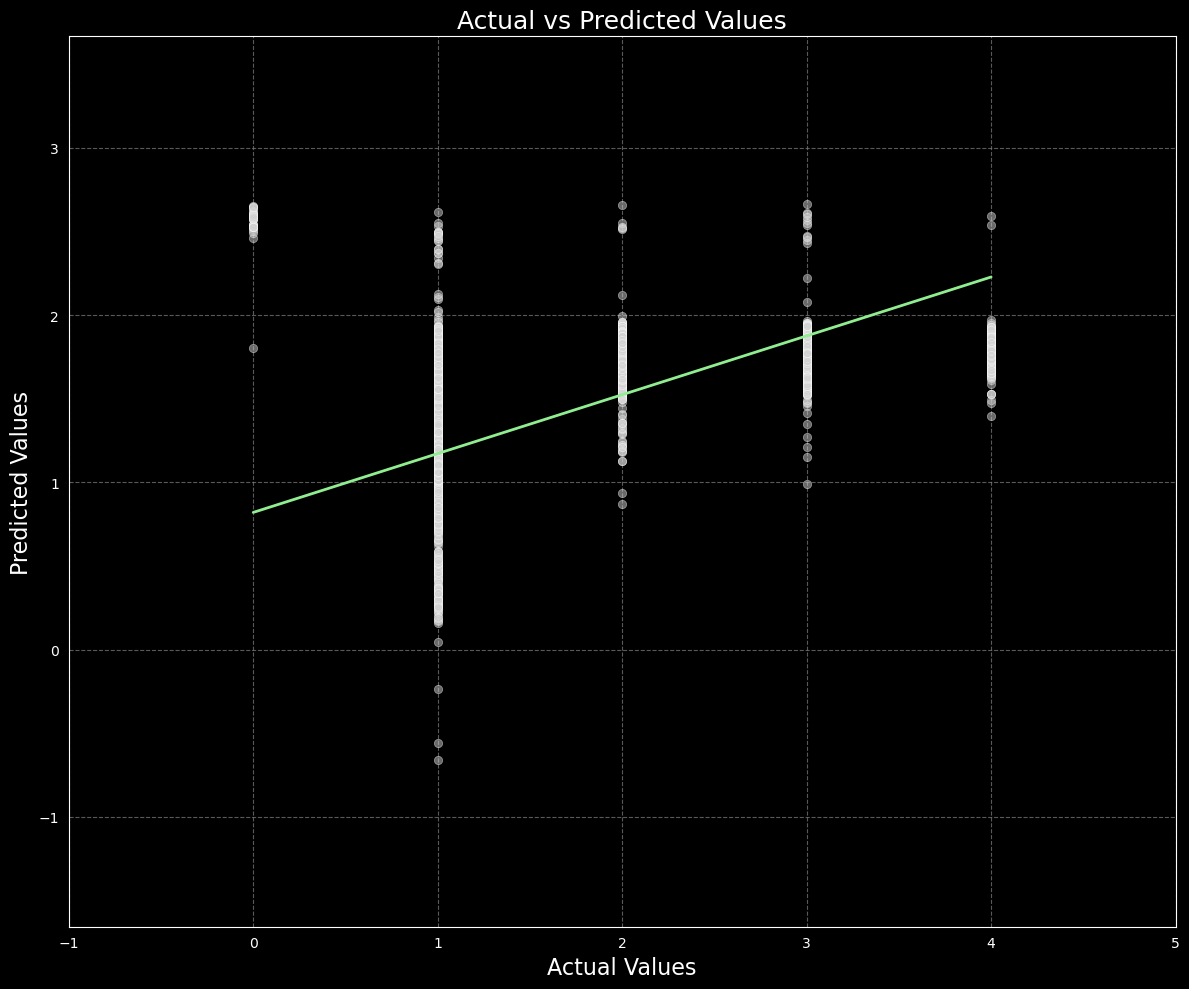

In [118]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import seaborn as sns


sns.set_style("darkgrid")
plt.style.use('dark_background')

plt.figure(figsize=(12, 10))

plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='white', linewidths=0.5, color='lightgray')
plt.xlabel('Actual Values', fontsize=16, color='white')
plt.ylabel('Predicted Values', fontsize=16, color='white')
plt.title('Actual vs Predicted Values', fontsize=18, color='white')

plt.grid(True, linestyle='--', alpha=0.7, color='gray')
plt.xlim(min(y_test)-1, max(y_test)+1)
plt.ylim(min(y_pred)-1, max(y_pred)+1)

x_range = np.linspace(min(y_test), max(y_test), 100)
y_range = np.poly1d(np.polyfit(y_test, y_pred, 1))(x_range)
plt.plot(x_range, y_range, color='lightgreen', linewidth=2)

plt.tight_layout()
plt.show()
